# Walls Do Not Touch Mass
Here, we will consider the moving barrier example where walls approach from the top and the bottom but they do not touch the trajectory of the mass.

In [16]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from collections import defaultdict
from PIL import Image

## Plotting functions


In [17]:
def plot_lists(list):
    name = ["Energy", "Violation of Continuty", "Violation of Constraint", "Violation of Interp"]
    # Plot a list of arrays
    fig, axs = plt.subplots(1, len(list), figsize=(15, 5))
    for i in range(len(list)):
        axs[i].set_xlabel('Iteration')
        axs[i].set_ylabel('Value')
        axs[i].set_title('Plot of ' + name[i])
        axs[i].plot(list[i])
    plt.show()

def plot_log(log):
    # Plot 'pre_lambda', 'lambda', and 'first_order_condition' using subplots with different colors
    fig, axs = plt.subplots(4, 1, figsize=(10, 18))
    
    axs[0].plot(log['U_prime_interp'], label='U_prime_interp', color='blue')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Value')
    axs[0].set_title('Plot of U_prime_interp')
    axs[0].legend()

    # Plot 'pre_lambda'
    axs[1].plot(log['pre_lambda'], label='pre_lambda', color='blue')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Value')
    axs[1].set_title('Plot of pre_lambda')
    axs[1].legend()
    
    # Plot 'lambda'
    axs[2].semilogy(log['lambda'], label='lambda', color='green')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Value')
    axs[2].set_title('Plot of lambda')
    axs[2].legend()
    
    # Plot 'first_order_condition'
    axs[3].semilogy(log['first_order_condition'], label='first_order_condition', color='red')
    axs[3].set_xlabel('Iteration')
    axs[3].set_ylabel('Value')
    axs[3].set_title('Plot of first_order_condition')
    axs[3].legend()
    
    plt.show()

In [18]:
T = 15
N1 = 30
N2 = 30

import numpy as np
import math

def create_arena(
    num_time_steps: int,
    speed: float,
    moving_wall_strength: float = 2,
    perimeter_strength: float = 1,
    wall_width: int = 10
) -> np.ndarray:
    """
    Create a 3D NumPy array (num_time_steps, 30, 30) with:
      1) A permanent boundary wall of 'perimeter_strength' (outer perimeter).
      2) Moving walls from top and bottom with 'moving_wall_strength',
         advancing vertically according to a (possibly fractional) speed.
      3) A user-specified horizontal band (wall_width) that determines 
         how wide the moving wall is in the horizontal direction.
         (Centered within the interior columns.)
    
    Parameters
    ----------
    num_time_steps : int
        Number of time steps (frames).
    speed : float
        Vertical speed of the interior walls in pixels/step (can be fractional).
        E.g., 0.5 => 1 vertical row every 2 time steps.
    moving_wall_strength : float
        Strength/value of the moving interior wall.
    perimeter_strength : float
        Strength/value of the permanent boundary wall (outermost rows/columns).
    wall_width : int
        Horizontal width (in columns) for the moving walls. 
        This band is centered within columns [1..28]. 
        If wall_width > 28, it is clamped to 28.
    
    Returns
    -------
    arena : np.ndarray of shape (num_time_steps, 30, 30)
        arena[i] is a 30×30 grid at time i, containing:
          - A permanent boundary (perimeter_strength).
          - Moving top/bottom walls (moving_wall_strength) in a 
            horizontally centered band of 'wall_width' columns.
    """
    
    # We have 30x30, with a 1-cell border on all sides => interior rows = 28, interior cols = 28
    max_interior_rows = 28
    max_interior_cols = 28
    
    # Clamp the horizontal wall width so it doesn't exceed the interior width
    effective_wall_width = min(wall_width, max_interior_cols)
    
    # Calculate how to center the horizontal band [start_col : end_col) within 1..28
    # Example: if effective_wall_width=10, then it's centered among columns 1..28.
    leftover_space = max_interior_cols - effective_wall_width  # e.g. 28 - 10 = 18
    # We'll split leftover_space in half (integer division)
    left_side = leftover_space // 2         # e.g. 9
    start_col = 1 + left_side               # e.g. 1 + 9 = 10
    end_col = start_col + effective_wall_width  # e.g. 10 + 10 = 20
    
    # Initialize (time_steps, 30, 30) to zeros
    arena = np.zeros((num_time_steps, 30, 30), dtype=float)
    
    for i in range(num_time_steps):
        # How many vertical rows from top/bottom to fill?
        top_fill = int(math.floor(i * speed))     # e.g. if speed=0.5, floor(2*0.5)=1
        bottom_fill = int(math.floor(i * speed))  # same as top in this example

        # Clip so we never exceed the 28 interior rows
        top_fill = min(top_fill, max_interior_rows)
        bottom_fill = min(bottom_fill, max_interior_rows)
        
        # Fill the top rows
        # from row 1 to row (1 + top_fill), but only in columns [start_col : end_col)
        if top_fill > 0:
            arena[i, 1 : 1 + top_fill, start_col : end_col] = moving_wall_strength
        
        # Fill the bottom rows
        # from row (29 - bottom_fill) up to row 29, only columns [start_col : end_col)
        if bottom_fill > 0:
            arena[i, 29 - bottom_fill : 29, start_col : end_col] = moving_wall_strength
        
        # Finally, set the permanent boundary (perimeter)
        arena[i, 0, :] = perimeter_strength    # top row
        arena[i, -1, :] = perimeter_strength   # bottom row
        arena[i, :, 0] = perimeter_strength    # left column
        arena[i, :, -1] = perimeter_strength   # right column
    
    return arena


H = create_arena(T, speed = 0.5, moving_wall_strength = 0.05, perimeter_strength = 1, wall_width = 30)
F = np.zeros((T,))

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)
rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 15./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 15./30.], cov=2./36**2)

def plot_arena(time_step):
    plt.imshow(H[time_step]>0, cmap='gray')
    plt.imshow(rho_0, alpha=0.5)
    plt.imshow(rho_1, alpha=0.5)
    plt.title(f"Arena at time {time_step}")
    plt.show()

interact(plot_arena, time_step=(0, T - 1))

interactive(children=(IntSlider(value=7, description='time_step', max=14), Output()), _dom_classes=('widget-in…

<function __main__.plot_arena(time_step)>

In [19]:
ll=(1.0, 1.0, 1.0)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1, niter=100, log=log)

Norm of H_sum: 451.0388537587423
Norm of IQ_plus_Q: 1.316383065930677
(1.0, 1.0, 1.0) (15, 30, 30)
Multiplier: 1.234567901234568e-06
Norm of Q[0]: 6.041522986797286
Norm of HQH: 0.00018926279524616768
Condition number of HQH: 52.30057394636254


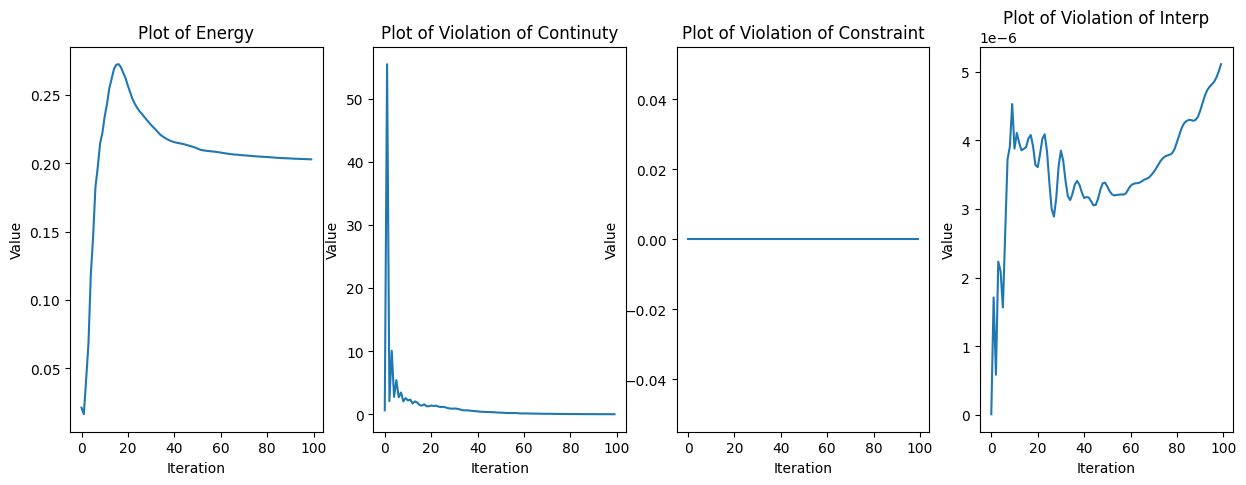

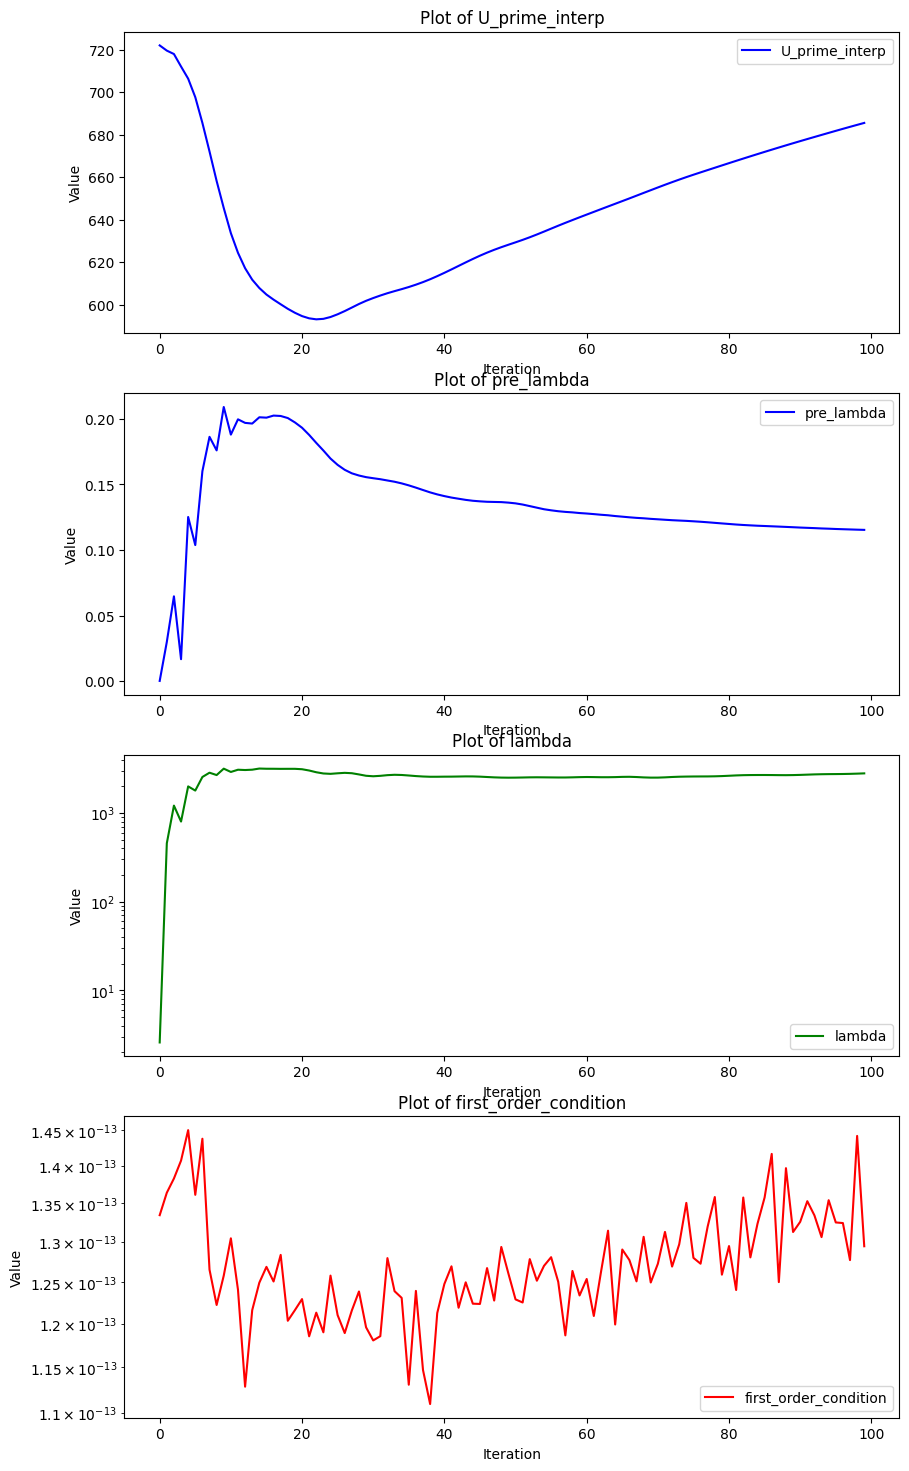

In [20]:
plot_lists(lists)
plot_log(log)

# Plotting the solution

In [21]:
def plot_maze_2(t, x, H, xx, yy, rho_0, rho_1, ismask=False):
    f, axes = plt.subplots(1, 3, figsize=[10, 5])

    ax1, ax2, ax3 = axes
    if t<=0:
        ax1.imshow(H[0]>0)
        ax1.imshow(rho_0, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[0], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    elif t>=T:
        ax1.imshow(H[T-1]>0)
        ax1.imshow(rho_1, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[T-1], vmin=-5, vmax=5)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][T-1], x.V.D[1][T-1], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    else:
        masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-3 , x.V.D[0][t])
        if ismask:
            ax1.imshow(masked1)
        else:
            ax1.imshow(H[t]>0)
            ax1.imshow(x.V.D[0][t], alpha=0.5)
        masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3 , x.V.Z[t])
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')  # Set color for masked values (zero values)
        ims2 = ax2.imshow(masked, vmin=-5, vmax=5)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')

    plt.show()


plot_elements9 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements9), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>